In [1]:
import numpy as np
import sklearn, sys
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler

## Version Numbers

In [2]:
libraries = (('Numpy', np), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.5.4 |Anaconda custom (x86_64)| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

Numpy Version: 1.13.1
Sklearn Version: 0.19.0


## Get Data

In [3]:
diabetes = load_diabetes()

In [4]:
X = diabetes.data  ## features
y = diabetes.target  ## target

In [5]:
print('dimensionality of features:', X.shape)
print('dimensionality of target:', y.shape)

dimensionality of features: (442, 10)
dimensionality of target: (442,)


In [296]:
X = np.random.randint(1,20,10)
y = np.dot(X, 0.5)

In [303]:
try:
    X.shape[1]
except:
    

IndexError: tuple index out of range

In [292]:
%matplotlib inline
import matplotlib.pyplot as plt

In [297]:
y

array([ 4.5,  9. ,  4. ,  6.5,  2.5,  1.5,  6. ,  3. ,  1. ,  4.5])

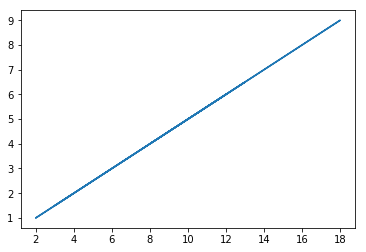

In [298]:
plt.plot(X, y)

## 1. Run Sklearn Linear Regression Model

In [6]:
# create linear regression object
lm = LinearRegression()

In [7]:
# train model
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
# show coefficient values
lm_coef = lm.coef_
lm_coef

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

## 2. Coefficients w/Linear Algebra
The closed form solution for finding linear regression coefficients: $\hat{\theta}$ = ($X^TX)^{-1}X^TY$

In [9]:
xtx = np.dot(X.T, X)
inv_xtx = np.linalg.inv(xtx)
xty = np.dot(X.T, y)

In [10]:
la_coef = np.dot(inv_xtx, xty)
la_coef

array([ -10.01219782, -239.81908937,  519.83978679,  324.39042769,
       -792.18416163,  476.74583782,  101.04457032,  177.06417623,
        751.27932109,   67.62538639])

## 3. Coefficients w/Gradient Descent

In [389]:
class batch_gradient_descent:
        
    def __init__(self, X, y, alpha=0.01, max_iter=5, seed=None):
        self.data = X
        self.target = y
        self.alpha_ = alpha
        try:
            self.nbfeatures_ = X.shape[1]
        except:
            self.nbfeatures_ = 1
        self.coef_ = np.random.rand(self.nbfeatures_)
        self.max_iter_ = max_iter
        self.iteration_ = 0
        self.predictions_ = np.zeros(len(y))
    
    def predictions(self):
        '''returns prediction given coefficients'''
        self.predictions_ = np.dot(self.data, self.coef_)
    
    def diff(self):
        '''returns difference between ground truth and predictions'''
        return self.predictions_ - self.target 
    
    def calculate_mse(self):
        '''returns the mean squared error'''
        delta = self.diff()
        squared_error = delta ** 2
        sse = np.sum(squared_error)
        return np.mean(sse)
    
    def weight_updates(self):
        self.coef_ = self.coef_ + np.dot(self.alpha_*np.sum(self.diff()), self.data)

    def fit(self):
        while self.iteration_ < self.max_iter_:
            print('Weights:', self.coef_)
            print('\nEpoch: {0} MSE: {1}'.format(self.iteration_, self.calculate_mse()))
            self.predictions()
            self.weight_updates()
            self.iteration_ += 1
            
    def predict(self, X):
        return np.dot(X, self.coef_)

In [390]:
gd = batch_gradient_descent(X, y, alpha=0.01, max_iter=5)

In [391]:
gd.coef_

array([ 0.21747161])

In [392]:
gd.calculate_mse()

234.25

In [393]:
gd.weight_updates()

In [394]:
gd.coef_

array([-3.60752839, -7.43252839, -3.18252839, -5.30752839, -1.90752839,
       -1.05752839, -4.88252839, -2.33252839, -0.63252839, -3.60752839])

In [395]:
gd.fit()

Weights: [-3.60752839 -7.43252839 -3.18252839 -5.30752839 -1.90752839 -1.05752839
 -4.88252839 -2.33252839 -0.63252839 -3.60752839]

Epoch: 0 MSE: 234.25
Weights: [-349.19844984 -698.61437129 -310.37445857 -504.49441493 -193.90248475
 -116.2545022  -465.67042366 -232.72647602  -77.43051093 -349.19844984]

Epoch: 1 MSE: 1474536.1557569534
Weights: [-33076.65871152 -66153.53489465 -29401.45024672 -47777.49257069
 -18375.82485235 -11025.40792276 -44102.28410589 -22051.03331714
  -7350.19945797 -33076.65871152]

Epoch: 2 MSE: 13223292092.881123
Weights: [-3132367.14549247 -6264734.50845656 -2784326.32738535 -4524530.41792096
 -1740203.87306399 -1044122.23684975 -4176489.59981383 -2088244.69117111
  -696081.41874263 -3132367.14549247]

Epoch: 3 MSE: 118587673104386.08
Weights: [ -2.96635176e+08  -5.93270353e+08  -2.63675712e+08  -4.28473032e+08
  -1.64797320e+08  -9.88783919e+07  -3.95513568e+08  -1.97756784e+08
  -6.59189279e+07  -2.96635176e+08]

Epoch: 4 MSE: 1.0635049252902326e+18


## Side-by-Side

In [ ]:
# Compare Scratch & Sklearn coefficients
import pandas as pd
pd.DataFrame(data=np.matrix([la_coef, lm.coef_]).reshape(2, 10).T, columns=['scratch', 'sklearn'])